# FLASH Implementation

## Foreword
We will be using $L$ hashtables; each with $K$-tuple rows. We will further limit each table to just $w$ rows which will mean that we will definitely get some extra collisions in that process. Moreover, we will further allocate them reservoirs from a global pool of reservoirs. We will again get collisions when we start allocating shared reservoirs between multiple tables. However, we are given guarantees by the main paper so we can rest assured.

Importing helpful packages

In [1]:
import numpy as np
import pandas as pd
import random
import struct
import math
import gzip

def fullprint(*args, **kwargs):
  from pprint import pprint
  import numpy
  opt = numpy.get_printoptions()
  numpy.set_printoptions(threshold=numpy.inf)
  pprint(*args, **kwargs)
  numpy.set_printoptions(**opt)

global L, w, K, R_total, R_per_table, R_shared

Now we will initialise the two structures that are important to be global. The set of hash tables and the reservoirs they access.

In [2]:
## Initialization
def create_Tables(N, Empty = np.nan): # all variables it creates are global
    """
        N = Dimension of input data
        L = Number of tables
        w = length of each table
        K = width of each row
    """
    global Tables, a_array, b_array, perm_function
    Tables = np.empty([L, w]) * Empty
    a_array = np.zeros([L, K])
    b_array = np.zeros([L, 1])
    perm_function = np.zeros([L, N]) # Each table owns its own permutation function
    for i in range(L): # For each table
        a_array[i] = np.random.normal(0, 1, K)
        b_array[i] = np.random.uniform(0, w)
        perm_function[i] = np.random.permutation(np.arange(N))
    perm_function = perm_function.astype(int)

def create_Reservoirs(): # this will be initialised with R empty values and newer entries would be appended to each row
    global Reservoir
    Reservoir = [[] for _ in range(R_total)]

Now we will have some helper functions for the main algorithm.

### DOPH

In [3]:
def DOPH_for_Lth_table(Datapoint, K, N, table_num, C = -1):
    """
    Datapoint : Data (will be converted to binary and then it will be zero-padded till it has size N)
    N : Size of Datapoint (Should be the maximum size possible for this format)
    K : Size of output of one table of LSH
    """
    if N%K != 0:
        N = N + K - N%K # Made N a multiple of K
    
    # print(f"Datapoint as is seen in {table_num}th table = {Datapoint}")
    binary_array = []
    for coordinate in Datapoint:
        binary_string = bin(coordinate)[2:]  # Convert coordinate to binary
        binary_string = binary_string.zfill(8)  # Extend to 8 bits
        binary_array.extend(list(binary_string))  # Concatenate to the array

    binary_array = np.array(binary_array, dtype=int)  # Convert the array to numpy array

    permuted_array = [binary_array[perm_function[table_num][i]] for i in range(N)]  # Permute the array according to the permutation function of that table
    divided_arrays = np.reshape(permuted_array, (K, N//K)) # each of the rows now is one of the chunks
    hash_tuple = np.zeros(K)
    for i in range(K):
        if np.max(divided_arrays[i]) < 1:
            hash_tuple[i] = C
        else:
            hash_tuple[i] = np.nonzero(divided_arrays[i])[0][0]
    # hash_tuple = [next((i for i, val in enumerate(row) if val != '0'), C) for row in divided_arrays] # Basically it chooses the first non-zero element in each row; if not found, it assigns it C
    # print(f"before rotation, hash_tuple looked in {table_num} as = ", hash_tuple)
    for i in range(len(hash_tuple)):
        if hash_tuple[i] == C:
            j = (i + 1) % len(hash_tuple)
            while j != i:
                if hash_tuple[j] != C:
                    hash_tuple[i] = hash_tuple[j] + ((j - i)% len(hash_tuple)) * C
                    break
                j = (j + 1) % len(hash_tuple)
    # print(f"shape of the hash_tuple in the {table_num}th table is = ",np.shape(hash_tuple))
    # print(f"hash_tuple for this image in the {table_num}th table is = ", hash_tuple)
    return hash_tuple

def DOPH(Datapoint, K, N, C = -1): # Does it for each of the tables
    hash_tuples = np.empty([1, K]) # First row is empty
    for i in range(L):
        hash_tuples = np.vstack([hash_tuples, DOPH_for_Lth_table(Datapoint, K, N, i, C)])
    return np.delete(hash_tuples, (0), axis=0)

### Mapping the K-tuples to addresses

In [4]:
def MapKHashesToAddress(Hash_tuple, Table_num):
    # print("a_array's size = ", np.shape(a_array[Table_num]))
    # print("Hash_tuple's size = ", np.shape(Hash_tuple))
    # print("Final value = ", np.dot(Hash_tuple, a_array[Table_num]) + b_array[Table_num])
    Key = np.floor(int(np.dot(Hash_tuple, a_array[Table_num]) + b_array[Table_num]) % w)
    # print("Pakka final key = ")
    return Key.astype(int)

### Reservoir Sampling

In [5]:
def ReservoirSampling(R, Stream):
    Reservoir = np.zeros(R)
    m = len(Stream)
    
    for i in range(R):
        Reservoir[i] = Stream[i]
    
    for i in range(R, m):
        j = random.randint(0, i)
        if j < R:
            Reservoir[j] = Stream[i]

In [6]:
def AllocateReservoir(table_num): # such a search based approach is only feasible for small R_per_tables
    # print("I am trying to allocate reservoir")
    start_index = table_num * R_per_table
    end_index = (table_num + 1) * R_per_table
    # print(f"start index = {start_index}")
    # print(f"end index = {end_index}")
    for i in range(start_index, end_index):
        if Reservoir[i] == []:
            # print("Reservoir selected is", i)
            return i # Thus the first empty index is returned
    # print("Private Reservoir is exhausted")
    return -1  # Return -1 if no empty index is found

## Adding Phase

In [7]:
## Algorithm 2 The Adding Phase
# def Add(DataPoint, table_num, Key, Empty=np.nan):
#     if Tables[table_num][Key] == Empty: # If that address is nascent
#         Tables[table_num][Key] = AllocateReservoir(table_num) # We will allocate based on the table number; it will try to allocate in the private reservoir of that table and then in the global shared ones.
#         ReservoirCounter = 0
#     Rand = random.randint(0, ReservoirCounter)
#     if Rand < R:
#         Reservoir[Rand] = DataPoint
#     ReservoirCounter += 1

## Above was the implementation according to the pseudo-code. Don't see the point in doing so
def Add(label, table_num, Key, Empty=np.nan):
    # print(f"Key that has be to added to {table_num}")
    # print(Key)
    # print(Tables[table_num][Key])
    if np.isnan(Tables[table_num][Key]): # If that address is nascent
        Pointer_to_reservoir = AllocateReservoir(table_num) # We will allocate based on the table number; it will try to allocate in the private reservoir of that table and then in the global shared ones.
        if Pointer_to_reservoir == -1: # If no space is available in the reservoir
            # print("We accessed global reservoirs")
            Pointer_to_reservoir = random.randint(L * R_per_table, R_total)
        Tables[table_num][Key] = Pointer_to_reservoir
    else:
        # print("I am here")
        Pointer_to_reservoir = Tables[table_num][Key]
    # print("pointer to reservoir is ",Pointer_to_reservoir)
    Reservoir[int(Pointer_to_reservoir)].append(label)

def Adding_Phase(DataPoints, Labels, N):
    """
        N = Dimension of input data
        DataPoints = Set of data (each row is a datapoint)
        Labels = The unique identifier for each of the datapoints
    """
    for i in range(len(DataPoints)): # parse each row
        Hash_tuples = DOPH(DataPoints[i], K, N) # For each datapoint, returns back K hashes for each table as rows
        # print("Hashtuples for this image is", Hash_tuples)
        for j in range(L):
            Key = MapKHashesToAddress(Hash_tuples[j], j) # For th ith datapoint, get the key for the jth table
            # print(Key)
            Add(Labels[i], j, Key) # Add this datapoint to the ith table at the key
        print(f"{i}th Image done.")

## Querying Phase

In [8]:
## Algorithm 3 The Querying Phase
def Querying_Phase(QueryPoints, TopK, N):
    results = []
    for QueryPoint in QueryPoints: # we will just deal with each of the queries one by one (in parallel with a loop)
        Hash_tuples = DOPH(QueryPoint, K, N) # get L rows of K-tuple (one K-tuple for each table)
        A = []
        for i in range(L):
            Key = (MapKHashesToAddress(Hash_tuples[i], i)) # we find the key for the ith table of the query point
            A.extend(Reservoir[int(Tables[i][Key])]) # append all of the labels in the reservoir at that location
        # print(A)
        i = KSelect(A, TopK) 
        results.append(i)
    return results

def KSelect(A, TopK):
    A.sort() # Sorting the pointers
    KV_Pair = CountFrequency(A)
    sorted_KV_Pair = sorted(KV_Pair.items(), key=lambda x: x[1], reverse=True) # Boht sus
    return sorted_KV_Pair[:TopK]


def CountFrequency(A):
    KV_Pair = {}
    for label in A:
        if label in KV_Pair:
            KV_Pair[label] += 1
        else:
            KV_Pair[label] = 1
    return KV_Pair

Testing it just because it looked sus af.

In [9]:
set_A = ['apple', 'god', 'don', 'don', 'elephant', 'cat', 'apple', 'god', 'france', 'apple', 'god', 'cat']
print(KSelect(set_A, 3))

[('apple', 3), ('god', 3), ('cat', 2)]


# Executable code
## Setting the stage

In [10]:
L = int(5)  # Number of tables
K = int(2)  # Number of hash functions per row
w = int(100) # Size of each table
R_total = int(2000) # Number of reservoirs
R_per_table = int(10)
R_shared = R_total - L * R_per_table # Each of the tables only gets 5 reservoirs exlcusively; others are shared

if R_shared < 0:
    print("Error: Not enough global reservoirs")
    exit()

N = int(28 * 28 * 8) # Depends on the type of data really

In [11]:
create_Tables(N) # Empty tables as well as the corresponding mapping functions have been initialized
create_Reservoirs() # Empty reservoirs have been initialized

print(a_array)
print(b_array)

[[ 0.17291287 -0.43420084]
 [ 0.13758854  0.27805583]
 [ 1.01965976 -0.0040841 ]
 [ 0.04457535 -0.50631528]
 [ 0.14397719 -0.08409342]]
[[15.89380679]
 [82.99317413]
 [90.40559137]
 [17.29448788]
 [66.18589226]]


## Getting the Datapoints
### MNIST DATA

In [12]:
import struct
def read_mnist(filename, number_of_images, kitna_chahiye):
    with open(filename, 'rb') as file:
        magic_number = struct.unpack('>I', file.read(4))[0]
        number_of_image = struct.unpack('>I', file.read(4))[0]
        n_rows = struct.unpack('>I', file.read(4))[0]
        n_cols = struct.unpack('>I', file.read(4))[0]
        print(magic_number, number_of_image, n_rows, n_cols)
        data = []
        for i in range(kitna_chahiye):
            images = []
            for r in range(n_rows):
                row = []
                for c in range(n_cols):
                    temp = struct.unpack('>B', file.read(1))[0]
                    row.append(float(temp))
                images.extend(row)
            data.extend(images)
        data = np.array(data)
        data=data.reshape(kitna_chahiye, 28 * 28)
        return data

def read_mnist_label(file_name, num_to_read, kitna_chahiye):
    with open(file_name, 'rb') as file:
        # Read the metadata
        magic_number = struct.unpack('>I', file.read(4))[0]
        number_of_images = struct.unpack('>I', file.read(4))[0]

        
        labels = np.zeros(kitna_chahiye, dtype=np.int32)

        for i in range(kitna_chahiye):
            temp = struct.unpack('>B', file.read(1))[0]
            labels[i] = temp
 
    return labels
# Define file paths

train_images_file = "MNIST_Data/train-images-idx3-ubyte"
train_labels_file = "MNIST_Data/train-labels-idx1-ubyte"

# Define parameters
kitna_chahiye = 500
image_size = 28 * 28  # MNIST images are 28x28 pixels

data=[]
data=read_mnist(train_images_file, 60000, kitna_chahiye)
labels= read_mnist_label(train_labels_file, 60000, kitna_chahiye)

data = data.astype(int)

2051 60000 28 28


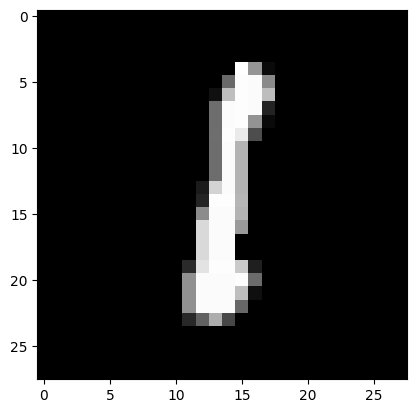

In [13]:
img = data[450].reshape(28, 28)
import matplotlib.pyplot as plt
plt.imshow(img, cmap='gray')
plt.show()

In [14]:
labels[450]

1

### Synthetic Data
This is data we know trends about thus would allow us to test the accuracy of our algorithm.

In [15]:
# L_star = 10
# N_star = 16
# perm_function_lmao = np.zeros([L_star, N_star]) # Each table owns its own permutation function
# for i in range(L_star): # For each table
#     perm_function_lmao[i] = np.random.permutation(np.arange(N_star))
# perm_function_lmao = perm_function_lmao.astype(int)
# print(perm_function_lmao)

# Datapoint = [15, 2]
# binary_array = []
# for coordinate in Datapoint:
#     binary_string = bin(coordinate)[2:]  # Convert coordinate to binary
#     binary_string = binary_string.zfill(8)  # Extend to 8 bits
#     binary_array.extend(list(binary_string))  # Concatenate to the array

# binary_array = np.array(binary_array, dtype=int)  # Convert the array to numpy array
# print(binary_array)
# permuted_array = [binary_array[perm_function_lmao[0][i]] for i in range(N_star)]
# print(permuted_array)
# print(28 * 28 * 8)

## Adding Datapoints to the HashTable & Reservoirs

In [16]:
Adding_Phase(data[:480], labels[:480], image_size * 8) # 8 bits per pixel

/tmp/ipykernel_43732/2824102134.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Key = np.floor(int(np.dot(Hash_tuple, a_array[Table_num]) + b_array[Table_num]) % w)


0th Image done.
1th Image done.
2th Image done.
3th Image done.
4th Image done.
5th Image done.
6th Image done.
7th Image done.
8th Image done.
9th Image done.
10th Image done.
11th Image done.
12th Image done.
13th Image done.
14th Image done.
15th Image done.
16th Image done.
17th Image done.
18th Image done.
19th Image done.
20th Image done.
21th Image done.
22th Image done.
23th Image done.
24th Image done.
25th Image done.
26th Image done.
27th Image done.
28th Image done.
29th Image done.
30th Image done.
31th Image done.
32th Image done.
33th Image done.
34th Image done.
35th Image done.
36th Image done.
37th Image done.
38th Image done.
39th Image done.
40th Image done.
41th Image done.
42th Image done.
43th Image done.
44th Image done.
45th Image done.
46th Image done.
47th Image done.
48th Image done.
49th Image done.
50th Image done.
51th Image done.
52th Image done.
53th Image done.
54th Image done.
55th Image done.
56th Image done.
57th Image done.
58th Image done.
59th Im

## Querying the datapoints

In [17]:
results = Querying_Phase([data[360]], 5, image_size * 8)
print(results)
print(labels[360])

[[(1, 82), (3, 76), (2, 63), (9, 49), (0, 46)]]
2


/tmp/ipykernel_43732/2824102134.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Key = np.floor(int(np.dot(Hash_tuple, a_array[Table_num]) + b_array[Table_num]) % w)


### Saving the state
#### MNIST

In [18]:
# import pickle
# np.save("hashtable_MNIST.npy", Tables)
# np.save("a_MNIST.npy", a_array)
# np.save("b_MNIST.npy", b_array)
# np.save("perm_function_MNIST.npy", perm_function)
# # Save the Reservoir list to a file
# with open('reservoir_MNIST.pkl', 'wb') as f:
#     pickle.dump(Reservoir, f)

# # Save the variables using Pickle
# with open('variables_MNIST.pkl', 'wb') as f:
#     pickle.dump(K, f)
#     pickle.dump(L, f)
#     pickle.dump(w, f)
#     pickle.dump(N, f)
#     pickle.dump(R_per_table, f)
#     pickle.dump(R_shared, f)
#     pickle.dump(R_total, f)
#     pickle.dump(Reservoir, f)
#     pickle.dump(Tables, f)
#     pickle.dump(a_array, f)
#     pickle.dump(b_array, f)
#     pickle.dump(data, f)
#     pickle.dump(image_size, f)
#     pickle.dump(kitna_chahiye, f)
#     pickle.dump(labels, f)
#     pickle.dump(perm_function, f)
#     pickle.dump(Tables, f)
#     pickle.dump(N, f)
#     pickle.dump(labels, f)
#     pickle.dump(perm_function, f)

### Loading the state
#### MNIST

In [19]:
# import pickle

# with open('reservoir_MNIST.pkl', 'rb') as f:
#     Reservoir = pickle.load(f)

# Tables = np.load("hashtable_MNIST.npy")
# a_array = np.load("a_MNIST.npy")
# b_array = np.load("b_MNIST.npy")
# perm_function = np.load("perm_function_MNIST.npy")

# Evaluation
## R@K
We will use K = 4

In [20]:
import time

def evaluate_model_RK(data, labels, TopK):
    start = time.time()
    queried = np.random.choice(480, 100)
    results = Querying_Phase(data[queried], TopK, image_size * 8)
    print("results aagaye")
    counter = 0
    labels_queried = labels[queried]
    for i in range(len(results)):
        neighbors = [t[0] for t in results[i]]
        if labels_queried[i] in neighbors:
            counter += 1
    end = time.time()
    return [counter/100, end-start]

[recall_acc, timer] = evaluate_model_RK(data, labels, 4)
print(recall_acc)
print(timer)

timer_list = np.load("timer_list.npy")
recall_acc_list = np.load("recall_acc_list.npy")
params_list = np.load("params_list.npy")

timer_list = np.append(timer_list, timer)
recall_acc_list = np.append(recall_acc_list, recall_acc)
params_list = np.append(params_list, [L, K])

np.save("timer_list.npy", timer_list)
np.save("recall_acc_list.npy", recall_acc_list)
np.save("params_list.npy", params_list)

/tmp/ipykernel_43732/2824102134.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Key = np.floor(int(np.dot(Hash_tuple, a_array[Table_num]) + b_array[Table_num]) % w)


results aagaye
0.75
2.9597747325897217


In [21]:
# timer_list = np.array([])
# recall_acc_list = np.array([])
# params_list = np.array([])
# np.save("timer_list.npy", timer_list)
# np.save("recall_acc_list.npy", recall_acc_list)
# np.save("params_list.npy", params_list)

In [22]:
checking = np.load("params_list.npy")
print(checking)

[25.  2. 25. 28. 25. 56.  5.  2.  5. 28.  5. 56.  5.  2.]


# Mega Evaluation

In [ ]:
import matplotlib.pyplot as plt

plt.plot([2, 28, 56], timer_list[3:], label = "L = 5")
plt.plot([2, 28, 56], timer_list[:3], label = "L = 25")
plt.title("Timing")
plt.xlabel("K")
plt.ylabel("Query times")
plt.legend()
plt.show()

plt.plot([2, 28, 56], recall_acc_list[3:], label = "L = 5")
plt.plot([2, 28, 56], recall_acc_list[:3], label = "L = 25")
plt.title("R@4")
plt.xlabel("K")
plt.ylabel("Recall Accuracy")
plt.legend()
plt.show()